In [3]:
import cv2
import imutils
import numpy as np
from matplotlib import pyplot as plt
font = cv2.FONT_HERSHEY_COMPLEX

In [4]:

def pre_process_image(img, skip_dilate=False):
    """Uses a blurring function, adaptive thresholding and dilation to expose the main features of an image."""

    # Gaussian blur with a kernal size (height, width) of 9.
    # Note that kernal sizes must be positive and odd and the kernel must be square.
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)

    # Adaptive threshold using 11 nearest neighbour pixels
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colours, so gridlines have non-zero pixel values.
    # Necessary to dilate the image, otherwise will look like erosion instead.
    proc = cv2.bitwise_not(proc, proc)

    if(not skip_dilate):
        # Dilate the image to increase the size of the grid lines.
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]])
        proc = cv2.dilate(proc, kernel)

    return proc

In [5]:

def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left - 100, top_right - 100, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side) + 100, int(side) + 100))

In [6]:
import operator

def find_corners(polygon):
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]
    
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    return find_corners(polygon)


    

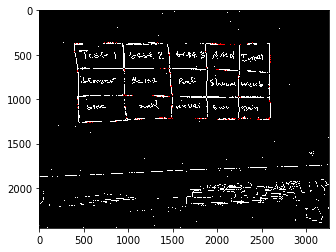

In [7]:
img = cv2.imread("/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg", cv2.IMREAD_GRAYSCALE)
# _, threshold = # Binary adaptive threshold using 11 nearest neighbour pixels
processed = pre_process_image(img, True)
ext_contours, _ = cv2.findContours(processed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours, _ = cv2.findContours(processed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

processed = cv2.cvtColor(processed, cv2.COLOR_GRAY2RGB)

# Draw all of the contours on the image in 2px red lines
# all_contours = cv2.drawContours(processed, contours, -1, (255, 0, 0), 2)
ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
largest = contours[0]  # Largest image
external_only = cv2.drawContours(processed, ext_contours[0], -1, (255, 0, 0), 2)

plt.imshow(processed)

# [plt.imshow(c[0], processed) for c in [('All Contours', all_contours), ('External Only', external_only)]]

In [8]:
def find_rectangles(img):
    contours, _ = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Draw all of the contours on the image in 2px red lines
    # all_contours = cv2.drawContours(processed, contours, -1, (255, 0, 0), 2)
    #     ext_contours = sorted(ext_contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    #     external_only = 
    rectangles = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.01 * peri, True)
        if(len(approx)) == 4:
            rectangles.append(approx)
    return rectangles

def draw_corners(img, corners):
    [cv2.circle(img, tuple(circle), 1, (255, 255, 255), 100) for circle in corners]

[array([399, 371], dtype=int32), array([2596,  375], dtype=int32), array([2597, 1229], dtype=int32), array([ 439, 1270], dtype=int32)]


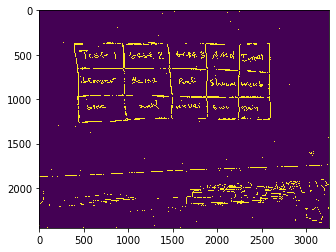

In [9]:
img = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, True)
corners = find_corners_of_largest_polygon(processed)

# See: https://gist.github.com/mineshpatel1/22e86200eee86ebe3e221343b26fc3f3#file-display_points-py
# cv2.drawContours(processed, corners, -1, (255, 0, 0), 2)
print(corners)
# draw_corners(processed, corners)
corners = find_corners_of_largest_polygon(processed)
plt.imshow(processed)

In [10]:
sorted(find_rectangles(cropped), key=cv2.contourArea, reverse = True)[:1]

NameError: name 'cropped' is not defined

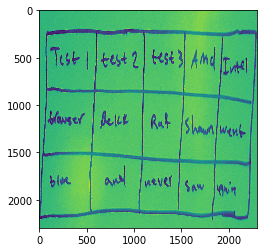

In [15]:
cropped = crop_and_warp(img, corners)
# plt.imshow(cropped)
# [cv2.drawContours(cropped, polygon, ) ]
# for index, polygon in enumerate(sorted(find_rectangles(cropped), key=cv2.contourArea, reverse=True)[:20]):
#     print(index, cv2.contourArea(polygon))
#     cv2.drawContours(cropped, polygon, -1, (0, 255, 0), 300)
plt.imshow(cropped)

In [ ]:
import cv2
import numpy as np

image  = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg')
cv2.imshow("Image", image)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)

blur = cv2.GaussianBlur(gray, (5,5), 0)
cv2.imshow("blur", blur)

thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
cv2.imshow("thresh", thresh)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
c = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > 1000:
        if area > max_area:
            max_area = area
            best_cnt = i
            image = cv2.drawContours(image, contours, c, (0, 255, 0), 3)
        c+=1

mask = np.zeros((gray.shape),np.uint8)
cv2.drawContours(mask,[best_cnt],0,255,-1)
cv2.drawContours(mask,[best_cnt],0,0,2)
cv2.imshow("mask", mask)

out = np.zeros_like(gray)
out[mask == 255] = gray[mask == 255]
cv2.imshow("New image", out)

blur = cv2.GaussianBlur(out, (5,5), 0)
cv2.imshow("blur1", blur)

thresh = cv2.adaptiveThreshold(blur, 255, 1, 1, 11, 2)
cv2.imshow("thresh1", thresh)

contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

c = 0
for i in contours:
    area = cv2.contourArea(i)
    if area > 1000/2:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.01 * peri, True)
        print(approx)
        cv2.drawContours(image, contours, c, (0, 255, 0), 3)
    c+=1


plt.imshow(image)


In [11]:
cv2.destroyAllWindows()

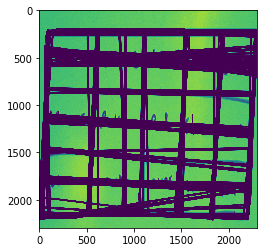

In [21]:
import numpy as np
import cv2

gray = cropped
edges = cv2.Canny(gray,50,150,apertureSize = 3)
cv2.imwrite('edges-50-150.jpg',edges)
minLineLength=10
lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=1000)

a,b,c = lines.shape
# print(lines)
for i in range(a):
    cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
plt.imshow(gray)

In [27]:
cropped.shape

(2297, 2297)

[INFO] loading EAST text detector...
[INFO] text detection took 7.249260 seconds


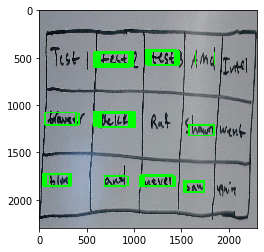

In [33]:
# USAGE
# python text_detection.py --image images/lebron_james.jpg --east frozen_east_text_detection.pb

# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2

# construct the argument parser and parse the arguments
args = {
    "image": '/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg',
    "width": cropped.shape[0] - (cropped.shape[0]%32),
    "height": cropped.shape[1] - (cropped.shape[0]%32),
    "east": "/Users/bekkblando/Documents/github/computer_vision/final_project/frozen_east_text_detection.pb",
    "min_confidence": .1
    
}

# load the input image and grab the image dimensions
img = cv2.imread('/Users/bekkblando/Documents/github/computer_vision/final_project/Table.jpg', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img, True)
corners = find_corners_of_largest_polygon(processed)


image = crop_and_warp(cv2.imread(args["image"]), corners)




orig = image.copy()
(H, W) = image.shape[:2]

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))

# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < args["min_confidence"]:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)

        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
# boxes = non_max_suppression(np.array(rects), probs=confidences)
boxes = rects

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

# show the output image
plt.imshow(orig)